In [25]:
import sys
#!{sys.executable} -m pip install fancyimpute 
#!{sys.executable} -m pip install tqdm 
#!{sys.executable} -m pip install gTTs

#!{sys.executable} -m pip install -q h5py pyyaml
#!{sys.executable} -m pip install -q tf_nightly

In [2]:
from fancyimpute import IterativeImputer

Using TensorFlow backend.


In [1]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import keras
from time import time
#from tensorflow.python.keras.callbacks import TensorBoard


Using TensorFlow backend.


In [4]:
dataset1 = pd.read_excel("Punjabi_bagh_2016.xlsx")
dataset2 = pd.read_excel("Punjabi_bagh_2017.xlsx")
dataset3 = pd.read_excel("Punjabi_bagh_2018.xlsx")
dataset4 = pd.read_excel("Punjabi_bagh_2019.xlsx")

In [5]:
dataset4 = dataset4.drop([4050, 4051, 4052, 4053, 4054, 4055])
dataset4.tail()

,From Date,To Date,BP,NO2,Ozone,PM10,PM2.5,AT,CO,NO,RH,SO2,SR,VWS,WD,WS
4045,18-06-2019 13:00,18-06-2019 14:00,734.19,21.48,54.5,59.75,None,30.77,0.62,3.07,36.53,8.62,120.8,0.15,89,2.02
4046,18-06-2019 14:00,18-06-2019 15:00,734.31,16.48,60.3,74.75,36,30.55,0.6,2.42,34.27,7.1,186.98,0,85,1.3
4047,18-06-2019 15:00,18-06-2019 16:00,734.25,19.88,62.97,59,36,29.77,0.67,2.6,0.9,11.4,156.38,0.1,78.5,1.12
4048,18-06-2019 16:00,18-06-2019 17:00,734.17,22.95,60.73,60.25,None,28.98,0.67,2.23,0.9,9.2,104.75,0.08,87.5,0.95
4049,18-06-2019 17:00,18-06-2019 17:54,734.03,21.15,63,64,None,28.52,0.77,1.95,0.9,10.38,72.33,0.08,69.5,1.27


In [6]:
print(len(dataset1)+len(dataset2)+len(dataset3)+len(dataset4))

30365


In [50]:
frames = [dataset1, dataset2, dataset3, dataset4]
result_date_index = pd.concat(frames, sort = True)
result_date_index = result_date_index.set_index(["To Date"])
result_date_index = result_date_index.drop(['Temp', 'THC', 'VWS', 'From Date'], axis=1)
#result_date_index.index = pd.to_datetime(result_date_index.index, dayfirst=True)

In [51]:
result_date_index.head()

,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
To Date,,,,,,,,,,,,,
01-01-2016 01:00,10.22,738,0.34,72.91,99.96,11.85,528.33,334,67.33,21.33,15,153.08,0.43
01-01-2016 02:00,9.37,738,0.47,94.07,86.74,11.23,528.67,354,70.83,26.85,14.92,145.92,0.3
01-01-2016 03:00,9.22,738,0.58,82.03,87.12,12.07,663.4,354,71.92,26.84,14.58,158.83,0.46
01-01-2016 04:00,8.96,738,1.03,48.89,84.37,11.44,619.67,354,72.33,26.66,14.75,150.25,0.3
01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350,73.33,16.59,14.75,146.25,0.31


In [52]:
#Do this befor adding date and time, cause else it makes it also nans
result = result_date_index.replace("None", np.nan)
result = result.replace(0, np.nan)
result = result.reset_index()
result = result.drop("To Date", axis = 1)

In [53]:
#Making the -ve values to Nan
for j in range(len(result.columns)): 
    df1 = result[result.columns[j]]
    for i in range(len(df1)):
        if df1.values[i] <  0:
            df1.values[i] = np.nan
    result.values[:, j] = df1.values
print(result.isnull().values.any())
result.head()

True


,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [91]:
#Take values in dataset_1 of those parameters which needs to be imputed
#dataset_1 = result[["NO2", "Ozone", "PM10", "PM2.5", "SO2", "NO", "CO", "AT", "BP", 'SR', "WD", "WS", "RH"  ]]
dataset_1 = result
result.tail()

,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
30360,30.77,734.19,0.62,3.07,21.48,54.50,59.75,NaN,36.53,8.62,120.80,89.0,2.02
30361,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,7.10,186.98,85.0,1.30
30362,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,11.40,156.38,78.5,1.12
30363,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,9.20,104.75,87.5,0.95
30364,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,10.38,72.33,69.5,1.27


In [101]:
print(dataset_1.isnull().values.any())
dataset_1.tail()

True


,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
30360,30.77,734.19,0.62,3.07,21.48,54.50,59.75,NaN,36.53,8.62,120.80,89.0,2.02
30361,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,7.10,186.98,85.0,1.30
30362,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,11.40,156.38,78.5,1.12
30363,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,9.20,104.75,87.5,0.95
30364,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,10.38,72.33,69.5,1.27


In [96]:
#Interpolate the Nan Values here else are dropped in the series_to_supervised function

#from fancyimpute import IterativeImputer
XY_incomplete = dataset_1.values[:, :]

n_imputations = 10
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(XY_incomplete))

XY_completed_mean = np.mean(XY_completed, 0)
XY_completed_std = np.std(XY_completed, 0)

#Save the imputed values in dataset_2
dataset_2 = pd.DataFrame(XY_completed_mean)
dataset_2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [105]:
dataset_2.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12
30360,30.77,734.19,0.62,3.07,21.48,54.50,59.75,-29.476394,36.53,8.62,120.80,89.0,2.02
30361,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.000000,34.27,7.10,186.98,85.0,1.30
30362,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.000000,0.90,11.40,156.38,78.5,1.12
30363,28.98,734.17,0.67,2.23,22.95,60.73,60.25,-27.189146,0.90,9.20,104.75,87.5,0.95
30364,28.52,734.03,0.77,1.95,21.15,63.00,64.00,-73.979470,0.90,10.38,72.33,69.5,1.27


In [98]:
#Revert back to previous indicies
#result.values[:,:] = dataset_2.values[:,:]
#print(dataset_2.isnull().values.any())
dataset_3 = dataset_2

In [106]:
#Making the -ve values to Nan
for j in range(len(dataset_3.columns)): 
    df1 = dataset_3[j]
    for i in range(len(df1)):
        if df1.values[i] <  0:
            df1.values[i] = np.nan
    dataset_3.values[:, j] = df1.values
#["NO2", "Ozone", "PM10", "PM2.5", "SO2", "NO", "CO", "AT", "BP", 'SR', "WD", "WS", "RH"  ]
dataset_3.isnull().values.any()

True

In [108]:
print(dataset_3.isnull().values.any())
dataset_3.tail()

True


,0,1,2,3,4,5,6,7,8,9,10,11,12
30360,30.77,734.19,0.62,3.07,21.48,54.50,59.75,NaN,36.53,8.62,120.80,89.0,2.02
30361,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,7.10,186.98,85.0,1.30
30362,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,11.40,156.38,78.5,1.12
30363,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,9.20,104.75,87.5,0.95
30364,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,10.38,72.33,69.5,1.27


In [134]:
#Now impute these Nan Values(placed in location of -ve values) with either knn or linear, etc.
dataset_3_further_interpolated = dataset_3.interpolate(method ='nearest', axis = 0, limit_direction='forward') 
#dataset_3_further_interpolated = dataset_3_further_interpolated.interpolate(method ='nearest', axis = 0, limit_direction='backward') 
#dataset_3_further_interpolated.plot(marker = '.',figsize = (20,20))
dataset_3_further_interpolated = dataset_3_further_interpolated.loc[:30362, :]
print(dataset_3_further_interpolated.isnull().values.any())
dataset_3_further_interpolated.tail()

False


,0,1,2,3,4,5,6,7,8,9,10,11,12
30358,31.80,734.66,0.62,3.77,25.20,42.05,55.25,5.0,7.15,7.00,350.07,76.75,0.98
30359,34.12,734.59,0.57,2.80,21.35,57.18,53.00,5.0,25.18,6.45,269.07,79.25,1.70
30360,30.77,734.19,0.62,3.07,21.48,54.50,59.75,5.0,36.53,8.62,120.80,89.00,2.02
30361,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,7.10,186.98,85.00,1.30
30362,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,11.40,156.38,78.50,1.12


In [131]:

#############################################################################

False

In [ ]:
final_result = pd.DataFrame(index=result.index, columns= result.columns)
final_result.values[:, :] = dataset_2.values[:, :]
final_result.tail()

In [ ]:
#plt.hlines(0, 0, 27000, colors='k', linestyles='solid')

dataset_3_further_interpolated_with_indexes.plot(marker = '.',figsize = (20,20))

In [ ]:
#plt.hlines(0, 0, 27000, colors='k', linestyles='solid')

final_result.plot(marker = '.',figsize = (40,40))
#result[0].plot(marker = '*',figsize = (20,20))

In [ ]:
final_result_linear = result.interpolate(method ='linear', limit_direction ='forward') 
final_result_linear.plot(marker = '.',figsize = (20,20))
final_result_linear.isnull().values.any()

In [ ]:
final_result_nearest = result.interpolate(method ='nearest') 
final_result_nearest.plot(marker = '.',figsize = (20,20))
final_result_nearest.isnull().values.any()

In [ ]:
dataset_3_further_interpolated_with_indexes.to_csv("H:\Celestini 2019\Dataset\punjabibagh-60\Punjabi_bagh_dataset_3_further_interpolated_with_indexes.csv")   

In [ ]:
dataset.head()

In [ ]:
"""import matplotlib.mlab as mlab
from sklearn.neighbors import KernelDensity

# Generate random samples from a mixture of 2 Gaussians
# with modes at 5 and 10
# Plot the true distribution
x = np.linspace(0, 400, 1000)[:, np.newaxis]
norm_vals = mlab.normpdf(x, 5, 1) * 0.25 + mlab.normpdf(x, 10, 1) * 0.75
plt.plot(x, norm_vals)

# Plot the data using a normalized histogram
plt.hist(df[0], 50)

# Do kernel density estimation
kd = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(df[[0]])

# Plot the estimated densty
kd_vals = np.exp(kd.score_samples(x))
plt.plot(x, kd_vals)

# Show the plots
plt.show()"""

In [ ]:
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset.head()

In [ ]:
dataset_3_further_interpolated_with_indexes = pd.read_csv("H:\Celestini 2019\Dataset\punjabibagh-60\Punjabi_bagh_dataset_3_further_interpolated_with_indexes.csv")   

In [152]:
#change the dataframe here to use to it convert into supervised
dataset = dataset_3_further_interpolated_with_indexes.set_index(["From Date"])

NameError: name 'dataset_3_further_interpolated_with_indexes' is not defined

In [ ]:
values = dataset.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_in=1, n_out=1, dropnan=True)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[23,24,26,28,31,32,34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 1000 * 24


train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
train_X.shape[1], train_X.shape[2]


In [ ]:
import keras
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from matplotlib import pyplot

model = Sequential()
model.add(LSTM(units = 5, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'tanh', recurrent_activation = 'hard_sigmoid', kernel_initializer= 'he_normal'))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mae')

# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size=24, validation_data=(test_X, test_y), callbacks=[keras.callbacks.TensorBoard(log_dir='./logs{}'.format(time()), histogram_freq=5)])

#plot loss and val_loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from keras import Sequential
from keras.layers import Dense,Dropout,LSTM,BatchNormalization
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5))

model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(train_X,train_y,epochs=30,batch_size=24,shuffle=False,
                validation_data=(test_X,test_y), callbacks=[keras.callbacks.TensorBoard(log_dir='./logs_dropout_batchnorm{}'.format(time()))])

In [ ]:
model.evaluate(x=test_X, y=test_y, batch_size=None, verbose=1) 

In [ ]:
y_hat = model.predict(test_X, batch_size=None, verbose=0, steps=None)

In [41]:
print(y_hat.shape)
print(test_X.shape)

NameError: name 'y_hat' is not defined

In [ ]:
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [ ]:
from numpy import concatenate
inv_yhat = np.concatenate((y_hat, test_X[:, 5:]),  axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:5]

In [ ]:
test_y = test_y.reshape((len(test_y), 5))
inv_y = concatenate((test_y, test_X[:, 5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:5]

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [27]:
##################Quantile losss ###########################
dataset_3_further_interpolated = pd.read_csv("H:\Celestini 2019\Dataset\punjabibagh-60\dataset_3_further_interpolated.csv")   
#dataset = dataset_3_further_interpolated_with_indexes.set_index(["To Date"])
#dataset.index = pd.to_datetime(dataset_3_further_interpolated_with_indexes["To Date"], dayfirst= True )
#dataset.head()
dataset_3_further_interpolated = dataset_3_further_interpolated.drop("Unnamed: 0", axis = 1)
dataset_3_further_interpolated.head()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,mt,yr,H,weekday,weekday_hour,m_weekday_CO,m_weekday_NO2,m_weekday_PM10,m_weekday_PM2.5,m_weekday_SO2
0,01-01-2016 01:00,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,...,1,2016,1,4,4 1,1.936279,96.906300,317.359128,130.223726,22.395368
1,01-01-2016 02:00,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,...,1,2016,2,4,4 2,1.697401,92.327867,304.253337,129.976150,21.597573
2,01-01-2016 03:00,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,...,1,2016,3,4,4 3,1.555527,82.448716,291.977495,124.162454,21.907678
3,01-01-2016 04:00,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,...,1,2016,4,4,4 4,1.464667,79.760979,287.085087,121.936639,23.044557
4,01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,...,1,2016,5,4,4 5,1.440171,75.460238,279.192906,123.575242,21.587912


In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import datetime
import tqdm

import tensorflow as tf
import keras.backend.tensorflow_backend as ktf

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard

In [7]:
#dataset_3_further_interpolated["timestamp"] = result_date_index.index
#If want to insert timestamp at beginning coloumn 
timestamp = result_date_index.index  
dataset_3_further_interpolated.insert(loc = 0, column = "timestamp", value = timestamp)

NameError: name 'result_date_index' is not defined

In [28]:
dataset_3_further_interpolated.head()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,mt,yr,H,weekday,weekday_hour,m_weekday_CO,m_weekday_NO2,m_weekday_PM10,m_weekday_PM2.5,m_weekday_SO2
0,01-01-2016 01:00,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,...,1,2016,1,4,4 1,1.936279,96.906300,317.359128,130.223726,22.395368
1,01-01-2016 02:00,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,...,1,2016,2,4,4 2,1.697401,92.327867,304.253337,129.976150,21.597573
2,01-01-2016 03:00,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,...,1,2016,3,4,4 3,1.555527,82.448716,291.977495,124.162454,21.907678
3,01-01-2016 04:00,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,...,1,2016,4,4,4 4,1.464667,79.760979,287.085087,121.936639,23.044557
4,01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,...,1,2016,5,4,4 5,1.440171,75.460238,279.192906,123.575242,21.587912


0.1176427898241991


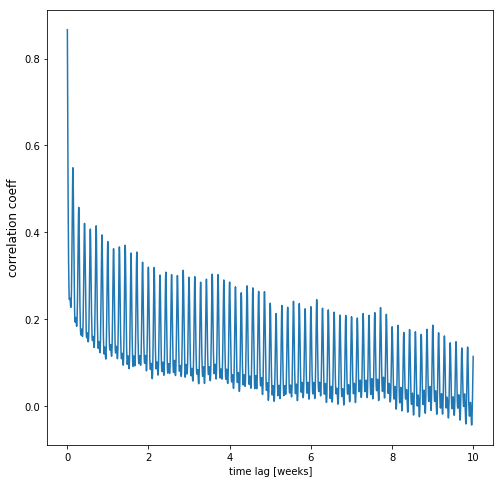

In [55]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###
timeLags = np.arange(1,10*24*7)
autoCorr = [dataset_3_further_interpolated[2].autocorr(lag=dt) for dt in timeLags]
print(np.mean(autoCorr))
plt.figure(figsize=(8,8))
plt.plot(1.0/(24*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [56]:
date = pd.DataFrame(np.vstack(dataset_3_further_interpolated.timestamp.apply(lambda x: re.sub(r':|-' ,' ', x).split()))[:,:4].astype(int))

dataset_3_further_interpolated = pd.concat([dataset_3_further_interpolated, date], axis=1)
dataset_3_further_interpolated.columns = ['timestamp', 'AT', 'BP', 'CO', 'NO', 'NO2', 'Ozone', 'PM10', 'PM2.5', 'RH', 'SO2', 'SR', 'WD', 'WS', 'd', 'mt', 'yr', 'H']

In [5]:
dataset_3_further_interpolated.tail()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,mt,yr,H,weekday,weekday_hour,m_weekday_CO,m_weekday_NO2,m_weekday_PM10,m_weekday_PM2.5,m_weekday_SO2
30360,18-06-2019 14:00,30.77,734.19,0.62,3.07,21.48,54.50,59.75,5.0,36.53,...,6,2019,14,1,1 14,1.150249,67.728244,245.873966,86.110025,18.860570
30361,18-06-2019 15:00,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,...,6,2019,15,1,1 15,1.095586,66.485506,235.008296,83.792890,19.301219
30362,18-06-2019 16:00,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,...,6,2019,16,1,1 16,1.060692,66.115734,215.824568,78.693864,16.740879
30363,18-06-2019 17:00,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,...,6,2019,17,1,1 17,1.148583,76.246409,215.305090,77.411489,17.490749
30364,18-06-2019 17:54,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,...,6,2019,17,1,1 17,1.148583,76.246409,215.305090,77.411489,17.490749


In [29]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###

##weekday = dataset_3_further_interpolated[['yr', 'mt', 'd']].apply(lambda x: datetime.datetime(x['yr'], x['mt'], x['d']).weekday(),axis=1).values
# weekend = weekday.copy()
# weekend[np.logical_and(weekend != 5, weekend != 6)] = 0
# weekend[weekend != 0] = 1

#Computed means for 22000 obs. Hence the train set will be 22000

##dataset_3_further_interpolated['weekday'] = weekday

##dataset_3_further_interpolated['weekday_hour'] = dataset_3_further_interpolated.weekday.astype(str) +' '+ dataset_3_further_interpolated.H.astype(str)


dataset_3_further_interpolated['m_weekday_CO'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['CO'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_NO2'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['NO2'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_PM10'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['PM10'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_PM2.5'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['PM2.5'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_SO2'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['SO2'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_AT'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['AT'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_BP'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['BP'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_NO'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['NO'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_Ozone'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['Ozone'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_RH'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['RH'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_SR'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['SR'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_WD'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['WD'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_WS'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['WS'].mean().to_dict())
dataset_3_further_interpolated.tail()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,m_weekday_PM2.5,m_weekday_SO2,m_weekday_AT,m_weekday_BP,m_weekday_NO,m_weekday_Ozone,m_weekday_RH,m_weekday_SR,m_weekday_WD,m_weekday_WS
30360,18-06-2019 14:00,30.77,734.19,0.62,3.07,21.48,54.50,59.75,5.0,36.53,...,86.110025,18.860570,26.761940,684.457931,16.137341,96.091520,38.360152,190.301054,76.993507,1.668394
30361,18-06-2019 15:00,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,...,83.792890,19.301219,26.789822,686.295074,13.600297,96.615691,38.093837,138.447440,75.656435,1.630538
30362,18-06-2019 16:00,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,...,78.693864,16.740879,26.483902,685.659846,14.074744,89.737811,38.657476,99.354114,74.423970,1.912728
30363,18-06-2019 17:00,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,...,77.411489,17.490749,25.451263,681.143217,16.017024,77.747091,40.370235,70.058690,75.441673,1.713897
30364,18-06-2019 17:54,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,...,77.411489,17.490749,25.451263,681.143217,16.017024,77.747091,40.370235,70.058690,75.441673,1.713897


In [31]:
dataset_3_further_interpolated = dataset_3_further_interpolated.loc[:30362]
dataset_3_further_interpolated.tail()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,m_weekday_PM2.5,m_weekday_SO2,m_weekday_AT,m_weekday_BP,m_weekday_NO,m_weekday_Ozone,m_weekday_RH,m_weekday_SR,m_weekday_WD,m_weekday_WS
30358,18-06-2019 12:00,31.80,734.66,0.62,3.77,25.20,42.05,55.25,5.0,7.15,...,102.231934,27.031637,25.835767,685.131829,16.528705,78.286294,41.628688,271.307587,79.315062,1.569707
30359,18-06-2019 13:00,34.12,734.59,0.57,2.80,21.35,57.18,53.00,5.0,25.18,...,91.498155,21.339851,26.773520,684.725816,16.632984,87.187258,39.407002,244.455738,77.301503,1.636415
30360,18-06-2019 14:00,30.77,734.19,0.62,3.07,21.48,54.50,59.75,5.0,36.53,...,86.110025,18.860570,26.761940,684.457931,16.137341,96.091520,38.360152,190.301054,76.993507,1.668394
30361,18-06-2019 15:00,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,...,83.792890,19.301219,26.789822,686.295074,13.600297,96.615691,38.093837,138.447440,75.656435,1.630538
30362,18-06-2019 16:00,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,...,78.693864,16.740879,26.483902,685.659846,14.074744,89.737811,38.657476,99.354114,74.423970,1.912728


In [9]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 24

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, (num_elements - seq_length), 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[(stop - sequence_length):stop].values.reshape((-1,len(seq_cols)))

In [10]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
def standardize_data(dataset_3_further_interpolated, sequence_length, seq_cols_name, seq_cols_m_weekday):
    cnt, mean = [], []
    for sequence in gen_index(dataset_3_further_interpolated, sequence_length, seq_cols_name):
        cnt.append(sequence)
    
    for sequence in gen_index(dataset_3_further_interpolated, sequence_length, seq_cols_m_weekday):
        mean.append(sequence)
    
    cnt, mean = np.log(cnt), np.log(mean)
    cnt = cnt - mean
    print(cnt.shape)
    return cnt


cnt_CO = standardize_data(dataset_3_further_interpolated, sequence_length,  ["CO"],  ['m_weekday_CO'])
cnt_NO2 = standardize_data(dataset_3_further_interpolated, sequence_length, ['NO2'],  ['m_weekday_NO2'])
cnt_PM10 = standardize_data(dataset_3_further_interpolated, sequence_length, ['PM10'],  ['m_weekday_PM10'])
cnt_PM2 = standardize_data(dataset_3_further_interpolated, sequence_length, ['PM2.5'],  ['m_weekday_PM2.5'])
cnt_SO2 = standardize_data(dataset_3_further_interpolated, sequence_length, ['SO2'],  ['m_weekday_SO2'])


(30339, 24, 1)
(30339, 24, 1)
(30339, 24, 1)
(30339, 24, 1)
(30339, 24, 1)


In [32]:
### CREATE GENERATOR FOR LSTM with multiple features###

sequence_length = 24

def gen_index_multiple(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, (num_elements - seq_length), 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[(stop - sequence_length):stop].values.reshape((-1,len(seq_cols)))

In [33]:
### CREATE AND STANDARDIZE DATA FOR LSTM  with multiple features### 
def standardize_data_multiple(dataset_3_further_interpolated, sequence_length, seq_cols_name, seq_cols_m_weekday = None):
    cnt, mean = [], []
    for sequence in gen_index_multiple(dataset_3_further_interpolated, sequence_length, seq_cols_name):
        cnt.append(sequence)
    
    for sequence in gen_index_multiple(dataset_3_further_interpolated, sequence_length, seq_cols_m_weekday):
        mean.append(sequence)
    
    cnt, mean = np.log(cnt), np.log(mean)
    cnt = cnt - mean
    print(cnt.shape)
    return cnt

multiple_columns = ['AT', 'BP', 'CO', 'NO', 'NO2', 'Ozone', 'PM10', 'PM2.5',
       'RH', 'SO2', 'SR', 'WD', 'WS']

cnt_multiple = standardize_data_multiple(dataset_3_further_interpolated, sequence_length, multiple_columns,  ['m_weekday_AT', 'm_weekday_BP', 'm_weekday_CO',
       'm_weekday_NO', 'm_weekday_NO2', 'm_weekday_Ozone', 'm_weekday_PM10',
       'm_weekday_PM2.5', 'm_weekday_RH', 'm_weekday_SO2', 'm_weekday_SR',
       'm_weekday_WD', 'm_weekday_WS'])


(30339, 24, 13)


In [34]:
### CREATE AND STANDARDIZE LABEL FOR LSTM with multiple features ###
init_multiple = dataset_3_further_interpolated[['m_weekday_CO', 'm_weekday_NO2', 'm_weekday_PM10', 'm_weekday_PM2.5', 'm_weekday_SO2']][sequence_length:].apply(np.log).values
label_multiple = dataset_3_further_interpolated[['CO', 'NO2', 'PM10', 'PM2.5', 'SO2']][sequence_length:].apply(np.log).values 
label_multiple = label_multiple - init_multiple
print(label_multiple.shape)

(30339, 5)


In [279]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init_CO = dataset_3_further_interpolated['m_weekday_CO'][sequence_length:].apply(np.log).values
label_CO = dataset_3_further_interpolated['CO'][sequence_length:].apply(np.log).values - init_CO
print(label_CO.shape)

init_NO2 = dataset_3_further_interpolated['m_weekday_NO2'][sequence_length:].apply(np.log).values
label_NO2 = dataset_3_further_interpolated['NO2'][sequence_length:].apply(np.log).values - init_NO2
print(label_NO2.shape)

init_PM10 = dataset_3_further_interpolated['m_weekday_PM10'][sequence_length:].apply(np.log).values
label_PM10 = dataset_3_further_interpolated['PM10'][sequence_length:].apply(np.log).values - init_PM10
print(label_CO.shape)

init_PM2 = dataset_3_further_interpolated['m_weekday_PM2.5'][sequence_length:].apply(np.log).values
label_PM2 = dataset_3_further_interpolated['PM2.5'][sequence_length:].apply(np.log).values - init_PM2
print(label_PM2.shape)

init_SO2 = dataset_3_further_interpolated['m_weekday_SO2'][sequence_length:].apply(np.log).values
label_SO2 = dataset_3_further_interpolated['SO2'][sequence_length:].apply(np.log).values - init_SO2
print(label_SO2.shape)

(30341,)
(30341,)
(30341,)
(30341,)
(30341,)


In [35]:
#DEFINE quantile loss
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
### TRAIN TEST SPLIT ###
X_train_CO, X_test_CO = cnt_CO[:22000], cnt_CO[22000:]
y_train_CO, y_test_CO = label_CO[:22000], label_CO[22000:]

In [37]:
X_train_multiple, X_test_multiple = cnt_multiple[:22000], cnt_multiple[22000:]
y_train_multiple, y_test_multiple = label_multiple[:22000], label_multiple[22000:]

In [27]:
def get_session(gpu_fraction=0.33):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


ktf.set_session(get_session())

In [52]:
### CREATE MODEL using Keras Functional API ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

def create_model():
        inputs = Input(shape=(X_train_multiple.shape[1], X_train_multiple.shape[2]))
        lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
        lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
        dense = Dense(50)(lstm)
        out10 = Dense(5)(dense)
        out50 = Dense(5)(dense)
        out90 = Dense(5)(dense)

        model = Model(inputs, [out10,out50,out90])

        model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
        
        return model
model = create_model()

In [53]:
# Saving Checkpoints
import os
checkpoint_path = "checkpoints_CO/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [54]:
y_train_multiple.shape

(22000, 5)

In [55]:
history = model.fit(X_train_multiple, [y_train_multiple,y_train_multiple,y_train_multiple], epochs=1, batch_size=128, verbose=2, shuffle=True, callbacks = [TensorBoard(log_dir='./logs/multiple_label_lstm'), tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)])

Epoch 1/1
 - 33s - loss: 0.1337 - dense_10_loss: 0.1378 - dense_11_loss: 0.2111 - dense_12_loss: 0.0967

Epoch 00001: saving model to checkpoints_CO/cp.ckpt


In [56]:
!dir {checkpoint_dir}

 Volume in drive H is New Volume
 Volume Serial Number is 0EE7-809D

 Directory of H:\Celestini 2019\Dataset\punjabibagh-60\checkpoints_CO

04-07-2019  13:28    <DIR>          .
04-07-2019  13:28    <DIR>          ..
04-07-2019  13:31           275,032 cp.ckpt
               1 File(s)        275,032 bytes
               2 Dir(s)  132,498,137,088 bytes free


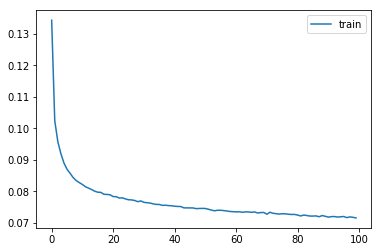

In [155]:
#plot loss and val_loss
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model_multiple.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_multiple.h5")
print("Saved model to disk")


NameError: name 'model' is not defined

In [20]:
# load json and create model # model.json, 
#model.h5 = for single feature CO, model_multiple.json, model_multiple.h5 = for multiple feature

json_file = open('model_multiple.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_multiple.h5")
print("Loaded model from disk")

Loaded model from disk


In [188]:
X_train_NO2, X_test_NO2 = cnt_NO2[:22000], cnt_NO2[22000:]
y_train_NO2, y_test_NO2 = label_NO2[:22000], label_NO2[22000:]

X_train_PM10, X_test_PM10 = cnt_PM10[:22000], cnt_PM10[22000:]
y_train_PM10, y_test_PM10 = label_PM10[:22000], label_PM10[22000:]

X_train_PM2, X_test_PM2 = cnt_PM2[:22000], cnt_PM2[22000:]
y_train_PM2, y_test_PM2 = label_PM2[:22000], label_PM2[22000:]

X_train_SO2, X_test_SO2 = cnt_SO2[:22000], cnt_SO2[22000:]
y_train_SO2, y_test_SO2 = label_SO2[:22000], label_SO2[22000:]

In [21]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 13)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 24, 128)      39936       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32)           18560       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1650        bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

In [40]:
### QUANTILEs BOOTSTRAPPING ###
def quantiles_bootstraping(model, X_test):
        pred_10, pred_50, pred_90 = [], [], []
        NN = K.function([model.layers[0].input, K.learning_phase()], 
                        [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])
        
        for i in tqdm.tqdm(range(0,100)):
            predd = NN([X_test, 0.5])
            pred_10.append(predd[0])
            pred_50.append(predd[1])
            pred_90.append(predd[2])

        pred_10 = np.asarray(pred_10)
        pred_50 = np.asarray(pred_50)
        pred_90 = np.asarray(pred_90)
        
        return pred_10, pred_50, pred_90
    
#pred_10_CO, pred_50_CO, pred_90_CO = quantiles_bootstraping(loaded_model, X_test_CO)

pred_10_multiple, pred_50_multiple, pred_90_multiple = quantiles_bootstraping(loaded_model, X_test_multiple)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.50it/s]


In [22]:
X_test_multiple.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [32]:
### REVERSE TRANSFORM PREDICTIONS ###
#pred_90_m_CO = np.exp(np.quantile(pred_90_CO,0.9,axis=0) + init_CO[22000:])
#pred_50_m_CO = np.exp(pred_50_CO.mean(axis=0) + init_CO[22000:])
#pred_10_m_CO = np.exp(np.quantile(pred_10_CO,0.1,axis=0) + init_CO[22000:])


### REVERSE TRANSFORM PREDICTIONS ###
def reverse_trans_predictions(pred_90, pred_50, pred_10, init, len_of_init):
        return np.exp(np.quantile(pred_90,0.9,axis=0) + init[len_of_init:]), np.exp(pred_50.mean(axis=0) + init[len_of_init:]), np.exp(np.quantile(pred_10,0.1,axis=0) + init[len_of_init:])


#pred_90_m_CO, pred_50_m_CO, pred_10_m_CO = reverse_trans_predictions(pred_10_CO, pred_50_CO, pred_90_CO, init_CO, len_of_init = 22000)

pred_90_m_multiple, pred_50_m_multiple, pred_10_m_multiple = reverse_trans_predictions(pred_10_multiple, pred_50_multiple, pred_90_multiple, init_multiple, len_of_init = 22000)

In [610]:
#Dont know why nans are coming
pred_10_m_multiple = np.delete(pred_10_m_multiple, 8340, axis = 0)
pred_50_m_multiple = np.delete(pred_50_m_multiple, 8340, axis = 0)
pred_90_m_multiple = np.delete(pred_90_m_multiple, 8340, axis = 0)

In [33]:
### EVALUATION METRIC ###
def evaluation_metric(y_test, init, len_of_init, pred_50_m):
    return mean_squared_log_error(np.exp(y_test + init[len_of_init:]), pred_50_m)
    
#print(evaluation_metric(y_test_CO, init_CO, len_of_init=22000, pred_50_m = pred_50_m_CO))
print(evaluation_metric(y_test_multiple[:-1,1], init_multiple[:-1, 1], len_of_init=22000, pred_50_m = pred_50_m_multiple[:-1, 1]))

0.10188309707641224


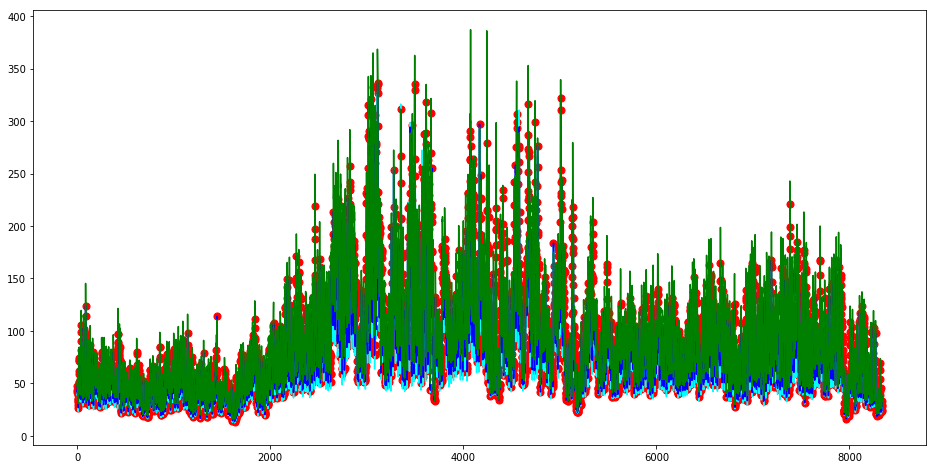

In [34]:
### PLOT QUANTILE PREDICTIONS ###
def plot_quantile_predictions(pred_10_m, pred_50_m, pred_90_m, plot_scatter = True):
    
        plt.figure(figsize=(16,8))
        if(pred_90_m is not None):
            plt.plot(pred_90_m, color='cyan')
        if(pred_50_m is not None):
            plt.plot(pred_50_m, color='blue')
        if(pred_10_m is not None):
            plt.plot(pred_10_m, color='green')

        ### CROSSOVER CHECK ###
        if(plot_scatter):
            plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
                pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50);
        
        
plot_quantile_predictions(pred_10_m_multiple[:-1,1], pred_50_m_multiple[:-1,1], pred_90_m_multiple[:-1,1])


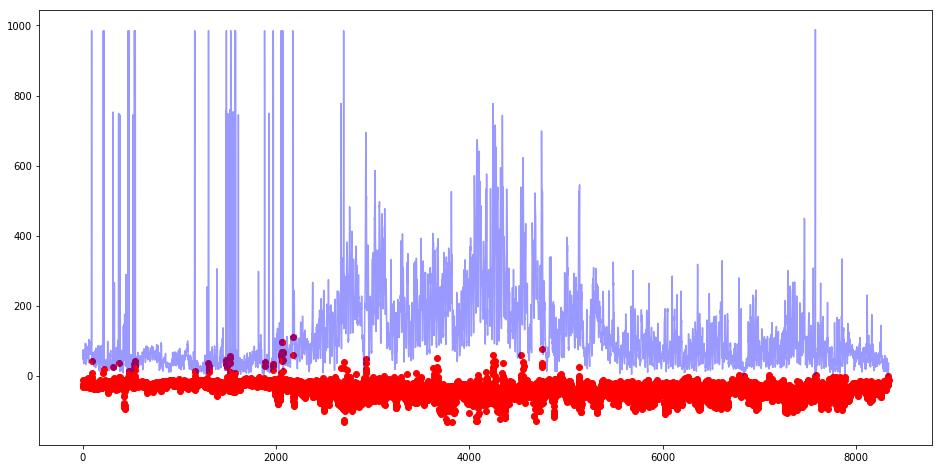

In [39]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
def plot_uncertainity_interval(y_test, init, len_of_init, pred_10_m, pred_50_m, pred_90_m):
        plt.figure(figsize=(16,8))
        plt.plot(np.exp(y_test + init[len_of_init:]), color='blue', alpha=0.4)
        plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color = "red")
        
#plot_uncertainity_interval(y_test_CO, init_CO, 22000, pred_10_m_CO, pred_50_m_CO, pred_90_m_CO)
plot_uncertainity_interval(y_test_multiple[:-1,3], init_multiple[:-1,3], 22000, pred_10_m_multiple[:-1,3], pred_50_m_multiple[:-1,3], pred_90_m_multiple[:-1,3])

In [ ]:
####################        MODEL 2          ###########################

In [44]:
### CREATE MODEL 2 ###

model2 = Model(inputs, [out10,out50,out90])

model2.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [47]:
history2 = model2.fit(X_train_NO2, [y_train_NO2,y_train_NO2,y_train_NO2], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50
 - 30s - loss: 0.0510 - dense_2_loss: 0.0432 - dense_3_loss: 0.0866 - dense_4_loss: 0.0401
Epoch 2/50
 - 26s - loss: 0.0503 - dense_2_loss: 0.0426 - dense_3_loss: 0.0855 - dense_4_loss: 0.0396
Epoch 3/50
 - 25s - loss: 0.0502 - dense_2_loss: 0.0428 - dense_3_loss: 0.0852 - dense_4_loss: 0.0395
Epoch 4/50
 - 26s - loss: 0.0500 - dense_2_loss: 0.0424 - dense_3_loss: 0.0851 - dense_4_loss: 0.0392
Epoch 5/50
 - 26s - loss: 0.0502 - dense_2_loss: 0.0426 - dense_3_loss: 0.0855 - dense_4_loss: 0.0391
Epoch 6/50
 - 27s - loss: 0.0498 - dense_2_loss: 0.0425 - dense_3_loss: 0.0846 - dense_4_loss: 0.0388
Epoch 7/50
 - 26s - loss: 0.0496 - dense_2_loss: 0.0421 - dense_3_loss: 0.0844 - dense_4_loss: 0.0390
Epoch 8/50
 - 27s - loss: 0.0500 - dense_2_loss: 0.0423 - dense_3_loss: 0.0851 - dense_4_loss: 0.0392
Epoch 9/50
 - 28s - loss: 0.0497 - dense_2_loss: 0.0422 - dense_3_loss: 0.0845 - dense_4_loss: 0.0389
Epoch 10/50
 - 28s - loss: 0.0498 - dense_2_loss: 0.0425 - dense_3_loss: 0.0846 - 

In [49]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model2.layers[0].input, K.learning_phase()], 
                [model2.layers[-3].output,model2.layers[-2].output,model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test_NO2, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


In [51]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init_NO2[22000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init_NO2[22000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init_NO2[22000:])

### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test_NO2 + init_CO[22000:]), pred_50_m)

11.14905702664781

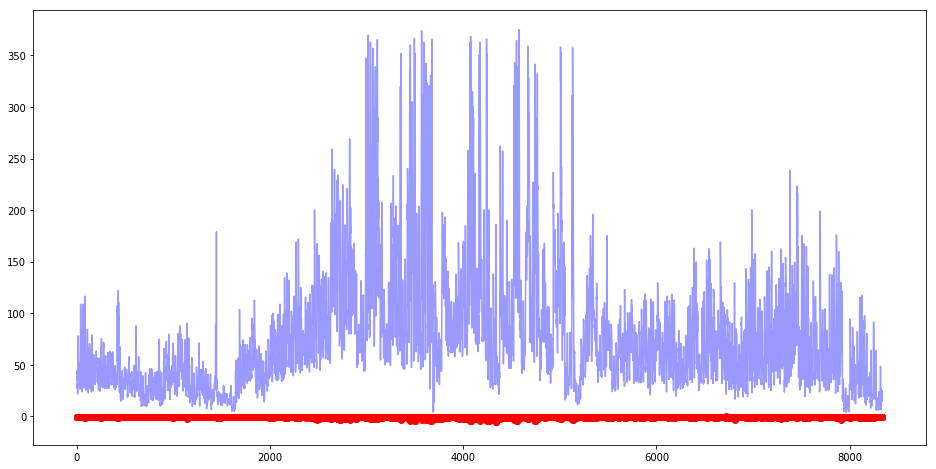

In [231]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test_NO2 + init_NO2[22000:]), color='blue', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color = "red")

In [53]:
####################        MODEL 3         ###########################

In [54]:
### CREATE MODEL 3 ###

model3 = Model(inputs, [out10,out50,out90])

model3.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [55]:
history3 = model3.fit(X_train_PM10, [y_train_PM10,y_train_PM10,y_train_PM10], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50
 - 30s - loss: 0.0549 - dense_2_loss: 0.0491 - dense_3_loss: 0.0927 - dense_4_loss: 0.0413
Epoch 2/50
 - 29s - loss: 0.0537 - dense_2_loss: 0.0471 - dense_3_loss: 0.0910 - dense_4_loss: 0.0408
Epoch 3/50
 - 25s - loss: 0.0534 - dense_2_loss: 0.0465 - dense_3_loss: 0.0907 - dense_4_loss: 0.0409
Epoch 4/50
 - 25s - loss: 0.0533 - dense_2_loss: 0.0464 - dense_3_loss: 0.0907 - dense_4_loss: 0.0407
Epoch 5/50
 - 25s - loss: 0.0531 - dense_2_loss: 0.0465 - dense_3_loss: 0.0898 - dense_4_loss: 0.0405
Epoch 6/50
 - 25s - loss: 0.0528 - dense_2_loss: 0.0462 - dense_3_loss: 0.0895 - dense_4_loss: 0.0404
Epoch 7/50
 - 26s - loss: 0.0529 - dense_2_loss: 0.0463 - dense_3_loss: 0.0894 - dense_4_loss: 0.0405
Epoch 8/50
 - 25s - loss: 0.0527 - dense_2_loss: 0.0460 - dense_3_loss: 0.0892 - dense_4_loss: 0.0404
Epoch 9/50
 - 25s - loss: 0.0524 - dense_2_loss: 0.0456 - dense_3_loss: 0.0890 - dense_4_loss: 0.0402
Epoch 10/50
 - 25s - loss: 0.0524 - dense_2_loss: 0.0459 - dense_3_loss: 0.0885 - 

In [56]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model3.layers[0].input, K.learning_phase()], 
                [model3.layers[-3].output,model3.layers[-2].output,model3.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test_PM10, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.51it/s]


In [57]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init_PM10[22000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init_PM10[22000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init_PM10[22000:])

### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test_PM10 + init_PM10[22000:]), pred_50_m)

0.0422232872502242

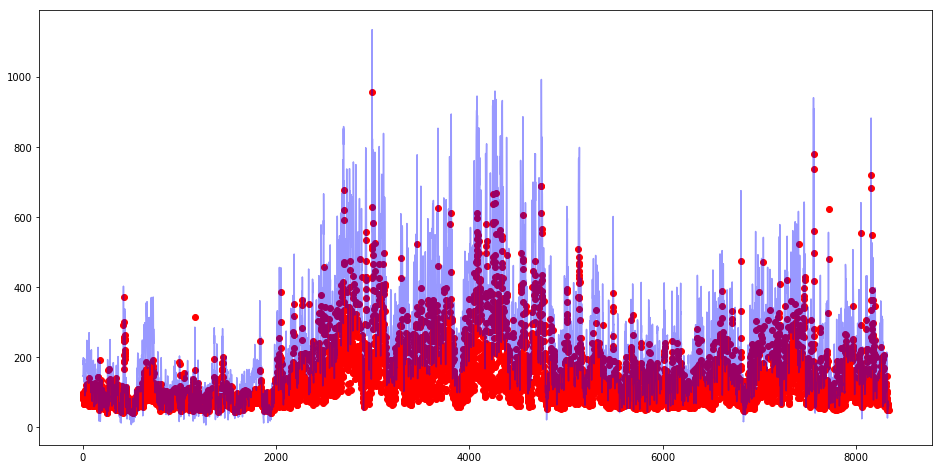

In [58]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test_PM10 + init_PM10[22000:]), color='blue', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color = "red")

In [59]:
####################        MODEL 4         ###########################

In [60]:
### CREATE MODEL 4 ###

model4 = Model(inputs, [out10,out50,out90])

model4.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [61]:
history4 = model4.fit(X_train_PM2, [y_train_PM2,y_train_PM2,y_train_PM2], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50
 - 27s - loss: 0.4833 - dense_2_loss: 0.4541 - dense_3_loss: 0.7708 - dense_4_loss: 0.3862
Epoch 2/50
 - 24s - loss: 0.3713 - dense_2_loss: 0.4377 - dense_3_loss: 0.6044 - dense_4_loss: 0.1956
Epoch 3/50
 - 24s - loss: 0.3690 - dense_2_loss: 0.4348 - dense_3_loss: 0.6019 - dense_4_loss: 0.1933
Epoch 4/50
 - 24s - loss: 0.3689 - dense_2_loss: 0.4354 - dense_3_loss: 0.6014 - dense_4_loss: 0.1929
Epoch 5/50
 - 24s - loss: 0.3684 - dense_2_loss: 0.4343 - dense_3_loss: 0.6011 - dense_4_loss: 0.1926
Epoch 6/50
 - 24s - loss: 0.3680 - dense_2_loss: 0.4335 - dense_3_loss: 0.6005 - dense_4_loss: 0.1925
Epoch 7/50
 - 25s - loss: 0.3680 - dense_2_loss: 0.4333 - dense_3_loss: 0.6007 - dense_4_loss: 0.1926
Epoch 8/50
 - 25s - loss: 0.3676 - dense_2_loss: 0.4331 - dense_3_loss: 0.6002 - dense_4_loss: 0.1921
Epoch 9/50
 - 25s - loss: 0.3682 - dense_2_loss: 0.4340 - dense_3_loss: 0.6010 - dense_4_loss: 0.1923
Epoch 10/50
 - 25s - loss: 0.3679 - dense_2_loss: 0.4334 - dense_3_loss: 0.6007 - 

In [62]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model4.layers[0].input, K.learning_phase()], 
                [model4.layers[-3].output,model4.layers[-2].output,model4.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test_PM2, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.10it/s]


In [63]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init_PM2[22000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init_PM2[22000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init_PM2[22000:])

### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test_PM2 + init_PM2[22000:]), pred_50_m)

C:\Users\Ankur\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

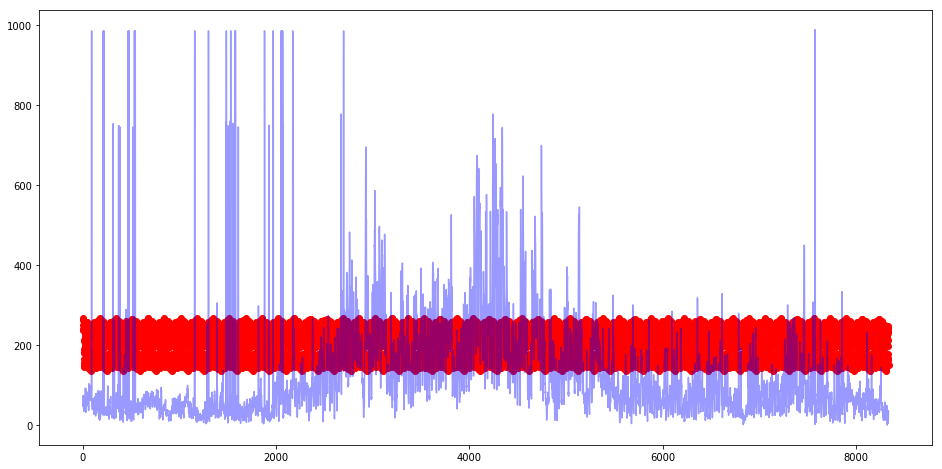

In [64]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test_PM2 + init_PM2[22000:]), color='blue', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color = "red")

In [ ]:
####################        MODEL 5         ###########################

In [65]:
### CREATE MODEL 5 ###

model5 = Model(inputs, [out10,out50,out90])

model5.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [66]:
history5 = model5.fit(X_train_SO2, [y_train_SO2,y_train_SO2,y_train_SO2], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50
 - 27s - loss: 0.1551 - dense_2_loss: 0.1718 - dense_3_loss: 0.2455 - dense_4_loss: 0.0996
Epoch 2/50
 - 24s - loss: 0.1480 - dense_2_loss: 0.1489 - dense_3_loss: 0.2452 - dense_4_loss: 0.0994
Epoch 3/50
 - 25s - loss: 0.1478 - dense_2_loss: 0.1489 - dense_3_loss: 0.2445 - dense_4_loss: 0.0993
Epoch 4/50
 - 24s - loss: 0.1471 - dense_2_loss: 0.1475 - dense_3_loss: 0.2437 - dense_4_loss: 0.0993
Epoch 5/50
 - 25s - loss: 0.1463 - dense_2_loss: 0.1465 - dense_3_loss: 0.2423 - dense_4_loss: 0.0988
Epoch 6/50
 - 25s - loss: 0.1445 - dense_2_loss: 0.1439 - dense_3_loss: 0.2400 - dense_4_loss: 0.0979
Epoch 7/50
 - 25s - loss: 0.1432 - dense_2_loss: 0.1418 - dense_3_loss: 0.2381 - dense_4_loss: 0.0973
Epoch 8/50
 - 25s - loss: 0.1420 - dense_2_loss: 0.1405 - dense_3_loss: 0.2360 - dense_4_loss: 0.0969
Epoch 9/50
 - 26s - loss: 0.1409 - dense_2_loss: 0.1385 - dense_3_loss: 0.2349 - dense_4_loss: 0.0963
Epoch 10/50
 - 25s - loss: 0.1396 - dense_2_loss: 0.1374 - dense_3_loss: 0.2326 - 

In [259]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model5.layers[0].input, K.learning_phase()], 
                [model5.layers[-3].output,model5.layers[-2].output,model5.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test_SO2, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

NameError: name 'model5' is not defined

In [68]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init_SO2[22000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init_SO2[22000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init_SO2[22000:])

### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test_SO2 + init_SO2[22000:]), pred_50_m)

0.2482219054412613

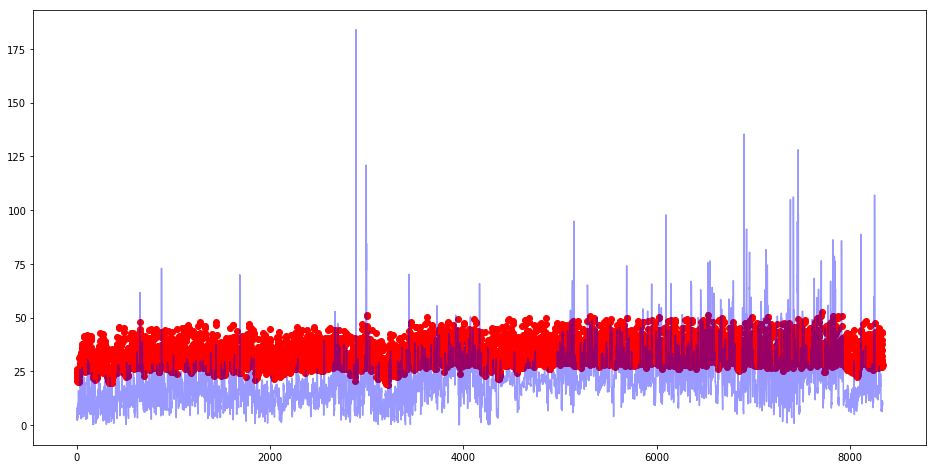

In [69]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test_SO2 + init_SO2[22000:]), color='blue', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color = "red")

In [ ]:
#####################################################################################

In [ ]:
#Crosscorrelation function
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [83]:
dataset_3_further_interpolated = dataset_3_further_interpolated.set_index(["timestamp"])
dataset_3_further_interpolated.head()

,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,...,mt,yr,H,weekday,weekday_hour,m_weekday_CO,m_weekday_NO2,m_weekday_PM10,m_weekday_PM2.5,m_weekday_SO2
timestamp,,,,,,,,,,,,,,,,,,,,,
01-01-2016 01:00,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,...,1,2016,1,4,4 1,1.936279,96.906300,317.359128,130.223726,22.395368
01-01-2016 02:00,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,...,1,2016,2,4,4 2,1.697401,92.327867,304.253337,129.976150,21.597573
01-01-2016 03:00,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,...,1,2016,3,4,4 3,1.555527,82.448716,291.977495,124.162454,21.907678
01-01-2016 04:00,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,...,1,2016,4,4,4 4,1.464667,79.760979,287.085087,121.936639,23.044557
01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,...,1,2016,5,4,4 5,1.440171,75.460238,279.192906,123.575242,21.587912


In [80]:
dataset_3_further_interpolated.to_csv("dataset_3_further_interpolated.csv")

In [90]:
dataset_3_further_interpolated.index = pd.to_datetime(dataset_3_further_interpolated.index, dayfirst=True)

In [91]:
dataset_2016 = dataset_3_further_interpolated.head(8783)
dataset_2017 = dataset_3_further_interpolated.iloc[8784: 17543, :]
dataset_2018 = dataset_3_further_interpolated.iloc[17544:26314, :]
dataset_2019 = dataset_3_further_interpolated.iloc[26315:, :]

In [92]:
#Drop the coloumns here / add the coloumns required here



In [149]:
jan_2016 = dataset_2016.loc[(dataset_2016.index.month == 1)]
feb_2016 = dataset_2016.loc[(dataset_2016.index.month == 2)]
mar_2016 = dataset_2016.loc[(dataset_2016.index.month == 3)]
apr_2016 = dataset_2016.loc[(dataset_2016.index.month == 4)]
may_2016 = dataset_2016.loc[(dataset_2016.index.month == 5)]
june_2016 = dataset_2016.loc[(dataset_2016.index.month ==6)]
july_2016 = dataset_2016.loc[(dataset_2016.index.month ==7)]
aug_2016 = dataset_2016.loc[(dataset_2016.index.month == 8)]
sept_2016 = dataset_2016.loc[(dataset_2016.index.month ==9)]
oct_2016 = dataset_2016.loc[(dataset_2016.index.month == 10)]
nov_2016 = dataset_2016.loc[(dataset_2016.index.month == 11)]
dec_2016 = dataset_2016.loc[(dataset_2016.index.month == 12)]

grishma_2016 = pd.concat([may_2016, june_2016])
vasant_2016 = pd.concat([mar_2016, apr_2016])
varsha_2016 = pd.concat([june_2016, july_2016])
sharad_2016 = pd.concat([sept_2016, oct_2016])
hemant_2016 = pd.concat([nov_2016, dec_2016])
shishir_2016 =  pd.concat([jan_2016, feb_2016])

jan_2017 = dataset_2017.loc[(dataset_2017.index.month == 1)]
feb_2017 = dataset_2017.loc[(dataset_2017.index.month == 2)]
mar_2017 = dataset_2017.loc[(dataset_2017.index.month == 3)]
apr_2017 = dataset_2017.loc[(dataset_2017.index.month == 4)]
may_2017 = dataset_2017.loc[(dataset_2017.index.month == 5)]
june_2017 = dataset_2017.loc[(dataset_2017.index.month ==6)]
july_2017 = dataset_2017.loc[(dataset_2017.index.month ==7)]
aug_2017 = dataset_2017.loc[(dataset_2017.index.month == 8)]
sept_2017 = dataset_2017.loc[(dataset_2017.index.month ==9)]
oct_2017 = dataset_2017.loc[(dataset_2017.index.month == 10)]
nov_2017 = dataset_2017.loc[(dataset_2017.index.month == 11)]
dec_2017 = dataset_2017.loc[(dataset_2017.index.month == 12)]

grishma_2017 = pd.concat([may_2017, june_2017])
vasant_2017 = pd.concat([mar_2017, apr_2017])
varsha_2017 = pd.concat([june_2017, july_2017])
sharad_2017 = pd.concat([sept_2017, oct_2017])
hemant_2017 = pd.concat([nov_2017, dec_2017])
shishir_2017 =  pd.concat([jan_2017, feb_2017])

jan_2018 = dataset_2018.loc[(dataset_2018.index.month == 1)]
feb_2018 = dataset_2018.loc[(dataset_2018.index.month == 2)]
mar_2018 = dataset_2018.loc[(dataset_2018.index.month == 3)]
apr_2018 = dataset_2018.loc[(dataset_2018.index.month == 4)]
may_2018 = dataset_2018.loc[(dataset_2018.index.month == 5)]
june_2018 = dataset_2018.loc[(dataset_2018.index.month ==6)]
july_2018 = dataset_2018.loc[(dataset_2018.index.month ==7)]
aug_2018 = dataset_2018.loc[(dataset_2018.index.month == 8)]
sept_2018 = dataset_2018.loc[(dataset_2018.index.month ==9)]
oct_2018 = dataset_2018.loc[(dataset_2018.index.month == 10)]
nov_2018 = dataset_2018.loc[(dataset_2018.index.month == 11)]
dec_2018 = dataset_2018.loc[(dataset_2018.index.month == 12)]

grishma_2018 = pd.concat([may_2018, june_2018])
vasant_2018 = pd.concat([mar_2018, apr_2018])
varsha_2018 = pd.concat([june_2018, july_2018])
sharad_2018 = pd.concat([sept_2018, oct_2018])
hemant_2018 = pd.concat([nov_2018, dec_2018])
shishir_2018 =  pd.concat([jan_2018, feb_2018])

jan_2019 = dataset_2019.loc[(dataset_2019.index.month == 1)]
feb_2019 = dataset_2019.loc[(dataset_2019.index.month == 2)]
mar_2019 = dataset_2019.loc[(dataset_2019.index.month == 3)]
apr_2019 = dataset_2019.loc[(dataset_2019.index.month == 4)]
may_2019 = dataset_2019.loc[(dataset_2019.index.month == 5)]
june_2019 = dataset_2019.loc[(dataset_2019.index.month ==6)]


grishma_2019 = pd.concat([may_2019, june_2019])
vasant_2019 = pd.concat([mar_2019, apr_2019])
shishir_2019 =  pd.concat([jan_2019, feb_2019])

In [1]:
fig, ax = plt.subplots(4, figsize = (30,16))
ax[0].plot(grishma_2016["CO"]) 
ax[1].plot(grishma_2017["CO"])
ax[2].plot(grishma_2018["CO"])
ax[3].plot(grishma_2019["CO"])

NameError: name 'plt' is not defined

In [337]:
std_CO = standardize_data(grishma_2016, sequence_length = 24, seq_cols_name= ['CO'],  seq_cols_m_weekday=['m_weekday_CO'])

(1440, 24, 1)


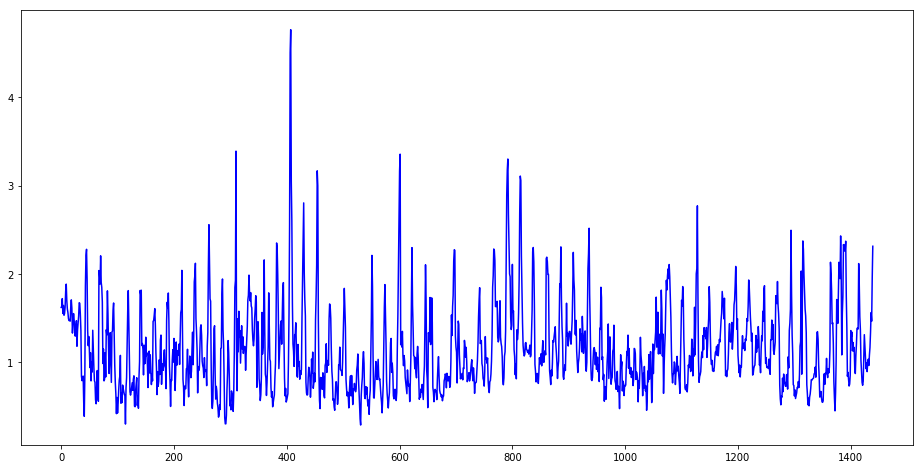

In [303]:
#pred_10_CO, pred_50_CO, pred_90_CO = quantiles_bootstraping(loaded_model, std_CO)

#init_CO = grishma_2016['m_weekday_CO'][sequence_length:].apply(np.log).values

pred_90_m_CO = np.exp(np.quantile(pred_90_CO,0.9,axis=0) + init_CO)
pred_50_m_CO = np.exp(pred_50_CO.mean(axis=0) + init_CO)
pred_10_m_CO = np.exp(np.quantile(pred_10_CO,0.1,axis=0) + init_CO)

plt.figsize = (30,16)
plot_quantile_predictions(pred_10_m = None, pred_50_m=  pred_50_m_CO, pred_90_m = None, plot_scatter=False)

In [315]:
pred_50_m_CO_data = pd.DataFrame(pred_50_m_CO.reshape((1440, 1)), index=grishma_2016.loc["2016-05-02 00:00:00":].index)

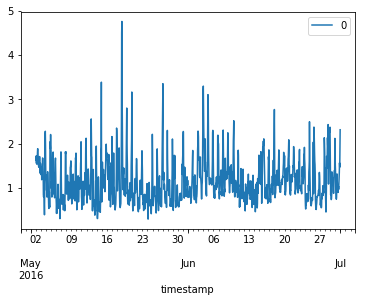

In [316]:
plt.figsize = (30,16)
pred_50_m_CO_data.plot()

In [351]:
pred_50_m_CO_data.shape

(1440, 1)

In [ ]:
plot_uncertainity_interval(y_test_CO, init_CO, 22000, pred_10_m_CO, pred_50_m_CO, pred_90_m_CO)